In [11]:
from kaggle_secrets import UserSecretsClient
import wandb
wandb.login(key=UserSecretsClient().get_secret("wandb_token"))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [55]:
from matplotlib import pyplot as plt
def plot_random_images_with_labels(images: np.ndarray, labels: np.ndarray, rows: int = 3, num_images: int = 7):
    fig, axes = plt.subplots(rows, num_images, figsize=(15, 5))
    for i in range(rows):
        for j in range(num_images):
            idx = np.random.randint(0, len(images))
            image = images[idx]
            points = labels[idx].reshape(-1, 2)
            axes[i, j].imshow(image)
            # scatter 
            axes[i, j].scatter(points[:, 0] * image.shape[1], points[:, 1] * image.shape[0], c='r', s=10)
            axes[i, j].axis('off')

    plt.show()

## Extract.py

In [13]:
import numpy as np
def extract(image: np.ndarray, points: np.ndarray) -> np.ndarray:
    """
    Extract the license plate from the image using homography of points
    :param image: Image to be extracted
    :param points: Points of the license plate
    :return: Extracted image with aspect ratio of 4.5
    """
    points_pixel = points * np.array([image.shape[1], image.shape[0]])
    
    width = int(np.linalg.norm(points_pixel[0] - points_pixel[1]))
    height = int(width / 4.5)
    # Find homography matrix
    homography_matrix, _ = cv2.findHomography(
        points_pixel, np.array([(0, 0), (width, 0), (width, height), (0, height)], dtype=np.float32))
    # Warp the image
    warped_image = cv2.warpPerspective(image, homography_matrix, (width, height))
    return warped_image

## Loader.py

In [31]:
input_shape = (256, 256, 3)

In [34]:
import os
import cv2
import numpy as np


def augment(image: np.ndarray, points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    aug_image, aug_points = image.copy(), points.copy()

    # Slight shifts
    max_shift = 0.2
    max_shift_x = min(1 - points[:, 0].max(), max_shift)
    min_shift_x = max(0 - points[:, 0].min(), -max_shift)
    shift_x = np.random.uniform(min_shift_x, max_shift_x) * image.shape[1]
    max_shift_y = min(1 - points[:, 1].max(), max_shift)
    min_shift_y = max(0 - points[:, 1].min(), -max_shift)
    shift_y = np.random.uniform(min_shift_y, max_shift_y) * image.shape[0]
    M_shift = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    aug_image = cv2.warpAffine(aug_image, M_shift, (aug_image.shape[1], aug_image.shape[0]))
    aug_points[:, 0] += shift_x / image.shape[1]
    aug_points[:, 1] += shift_y / image.shape[0]

    # Blurs
    ksize = np.random.choice([3, 5, 7, 11])
    aug_image = cv2.GaussianBlur(aug_image, (ksize, ksize), 0)

    # Noise Injection
    noise = np.random.randn(*aug_image.shape) * 25  # Adjust noise level
    aug_image = np.clip(aug_image + noise, 0, 255).astype(np.uint8)

    # Crops
    crop_fraction = 0.1  # crop up to 10% of the image dimensions
    crop_x = int(crop_fraction * image.shape[1])
    crop_y = int(crop_fraction * image.shape[0])
    x1, y1 = np.random.randint(0, crop_x), np.random.randint(0, crop_y)
    x2, y2 = aug_image.shape[1] - np.random.randint(0, crop_x), aug_image.shape[0] - np.random.randint(0, crop_y)
    aug_image, aug_points = crop_image(aug_image, aug_points, x1, x2, y1, y2)

    # Rotations
    angle = np.random.uniform(-15, 15)
    M_rot = cv2.getRotationMatrix2D((aug_image.shape[1] / 2, aug_image.shape[0] / 2), angle, 1)
    aug_image = cv2.warpAffine(aug_image, M_rot, (aug_image.shape[1], aug_image.shape[0]))
    ones = np.ones(shape=(len(aug_points), 1))
    aug_points_homogeneous = np.hstack([aug_points * [aug_image.shape[1], aug_image.shape[0]], ones])
    aug_points = M_rot.dot(aug_points_homogeneous.T).T
    aug_points[:, 0] /= aug_image.shape[1]
    aug_points[:, 1] /= aug_image.shape[0]

    # Crop to square around points
    x1, x2, y1, y2 = get_square_around_points(aug_image, aug_points)
    aug_image, aug_points = crop_image(aug_image, aug_points, x1, x2, y1, y2)

    # Contrast adjustments
    alpha = np.random.uniform(0.8, 1.2)  # contrast control
    beta = np.random.uniform(-20, 20)  # brightness control
    aug_image = cv2.convertScaleAbs(aug_image, alpha=alpha, beta=beta)

    # Ensure points are valid
    is_points_in_bound = np.all(aug_points >= 0) and np.all(aug_points <= 1)
    if not is_points_in_bound or np.any(np.isnan(aug_points)):
        return None, None
    return aug_image, aug_points


def get_square_around_points(image, points):
    width, height = image.shape[1], image.shape[0]
    square_size = min(width, height)
    aspect_ratio = width / height
    # Unnormalize points
    unnorm_x_min = points[:, 0].min() * width
    unnorm_x_max = points[:, 0].max() * width
    unnorm_y_min = points[:, 1].min() * height
    unnorm_y_max = points[:, 1].max() * height
    # Crop the image, making sure the bounding box stays inside the image
    if unnorm_x_max - unnorm_x_min > square_size:
        crop_x1, crop_x_width = unnorm_x_min, unnorm_x_max - unnorm_x_min
        crop_y1, crop_y_width = 0, square_size
    elif unnorm_y_max - unnorm_y_min > square_size:
        crop_x1, crop_x_width = 0, square_size
        crop_y1, crop_y_width = unnorm_y_min, unnorm_y_max - unnorm_y_min
    else:
        # A square centered around the bounding box
        crop_x1 = (unnorm_x_min + unnorm_x_max) / 2 - square_size / 2 if aspect_ratio > 1 else 0
        crop_y1 = (unnorm_y_min + unnorm_y_max) / 2 - square_size / 2 if aspect_ratio < 1 else 0
        crop_x_width, crop_y_width = square_size, square_size
        if crop_x1 + crop_x_width > width:
            crop_x1 = width - square_size
        elif crop_x1 < 0:
            crop_x1 = 0
        if crop_y1 + crop_y_width > height:
            crop_y1 = height - square_size
        elif crop_y1 < 0:
            crop_y1 = 0
    crop_x1, crop_y1 = int(crop_x1), int(crop_y1)
    crop_x_width, crop_y_width = int(crop_x_width), int(crop_y_width)
    return crop_x1, crop_x1 + crop_x_width, crop_y1, crop_y1 + crop_y_width


def augment_dataset(images, labels, augment_prob=0.2):
    augmented_images, augmented_labels = [], []
    for image, label in zip(images, labels):
        if np.random.rand() > augment_prob:
            continue
        aug_image, aug_label = augment(image, label)
        if aug_image is not None:
            augmented_images.append(aug_image)
            augmented_labels.append(aug_label)
    return augmented_images, np.array(augmented_labels)


def crop_image(img, points, x1, x2, y1, y2):
    crop_img = img[y1:y2, x1:x2].copy()
    cropped_points = points.copy()
    cropped_points[:, 0] = (points[:, 0] * img.shape[1] - x1) / (x2 - x1)
    cropped_points[:, 1] = (points[:, 1] * img.shape[0] - y1) / (y2 - y1)
    return crop_img, cropped_points


def resize_image(image: np.ndarray, points: np.ndarray, target_size) -> tuple[np.ndarray, np.ndarray]:
    image = cv2.resize(image, target_size)
    return image, points


def resize_dataset(images, labels, target_size=(input_shape[0], input_shape[0])):
    resized_images = []
    resized_labels = []
    for image, label in zip(images, labels):
        resized_image, resized_label = resize_image(image, label, target_size)
        resized_images.append(resized_image)
        resized_labels.append(resized_label)
    return np.array(resized_images), np.array(resized_labels)


def load(dir_name: str) -> tuple[np.ndarray, np.ndarray]:
    image_dir = os.path.join(dir_name, 'images')
    label_dir = os.path.join(dir_name, 'labels')

    images = []
    labels = []

    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            image_id = label_file.split('.')[0]
            image_path = os.path.join(image_dir, f'{image_id}.jpg')
            label_path = os.path.join(label_dir, label_file)

            if os.path.exists(image_path):
                # Read image
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Read label
                with open(label_path, 'r') as file:
                    label_data = file.readline().strip().split()
                    points = np.array([float(coord) for coord in label_data[1:]]).reshape(-1, 2)

                images.append(image)
                labels.append(points)

    labels = np.array(labels)
    labels = labels.reshape(-1, 4, 2)

    return images, labels

In [26]:
dir_name = '/kaggle/input/kntu-cv-4022-license-plate'
X, y = load(dir_name)
print(f'Loaded {len(X)} images and {len(y)} labels')

Loaded 1883 images and 1883 labels


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_aug, y_train_aug = augment_dataset(X_train, y_train, augment_prob=0.3)
X_train, y_train = X_train_aug + X_train, np.concatenate([y_train, y_train_aug])
X_train, y_train = resize_dataset(X_train, y_train, (input_shape[0], input_shape[1]))
X_valid, y_valid = resize_dataset(X_valid, y_valid, (input_shape[0], input_shape[1]))

Random seed: 801


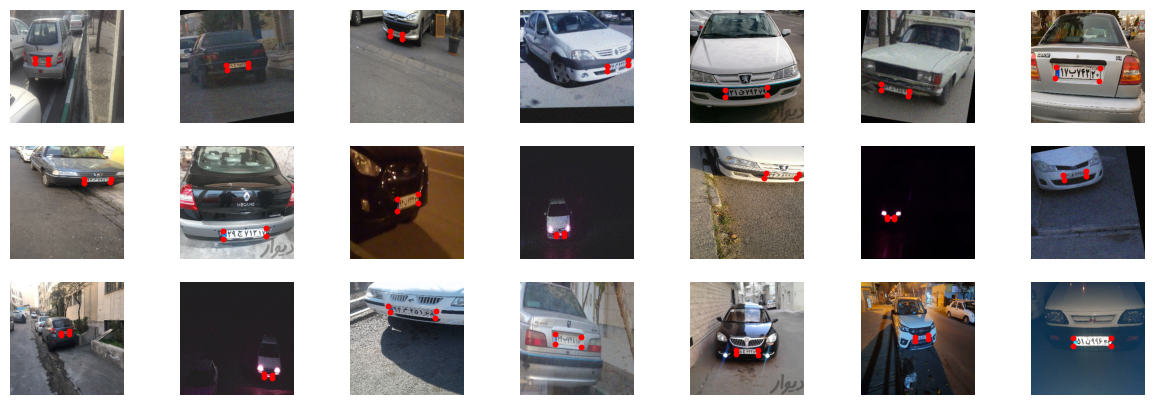

In [6]:
random_seed = np.random.randint(0, 1000)
np.random.seed(83)
print(f'Random seed: {random_seed}')

plot_random_images_with_labels(X, y)

## Regressor.py

## Single-GPU Training

In [50]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [51]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from keras.regularizers import l2
def create_model():
    inputs = keras.layers.Input(shape=input_shape)
    # Convolutional layers
    x = keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    x = keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
#     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((4, 4))(x)

    x = keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
#     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    # Fully connected layers

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(768, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(256, activation='relu')(x)
#     x = keras.layers.Dropout(0.5)(x)

    # Output layer
    outputs = keras.layers.Dense(8, activation='sigmoid')(x)

    # Define the model
    model = Model(inputs, outputs)

    return model

In [52]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289,608 (77.40 MB)

 Trainable params: 20,289,608 (77.40 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# initial_learning_rate = 0.002
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [54]:
import wandb
wandb.init(project='license-plate-recognition')
wandb.config = {
    "model_params": np.sum([np.prod(v.shape) for v in model.trainable_weights]),
    "layers": [l['name'] for l in model.get_config()['layers']],
}

from tensorflow.keras.callbacks import Callback
class CustomWandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            wandb.log({
                'epoch': epoch,
                'loss': logs['loss'],
                'val_loss': logs['val_loss'],
                'mae': logs['mae'],
                'val_mae': logs['val_mae'],
#                 'lr': self.model.optimizer.lr.numpy()
            })

In [60]:
callbacks = [
    CustomWandbCallback(),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

In [61]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)
model.save('model.keras')

Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - loss: 0.0093 - mae: 0.0192 - val_loss: 0.0106 - val_mae: 0.0256
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - loss: 0.0089 - mae: 0.0182 - val_loss: 0.0103 - val_mae: 0.0254
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - loss: 0.0085 - mae: 0.0170 - val_loss: 0.0101 - val_mae: 0.0247
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - loss: 0.0083 - mae: 0.0174 - val_loss: 0.0096 - val_mae: 0.0251
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - loss: 0.0080 - mae: 0.0171 - val_loss: 0.0094 - val_mae: 0.0248
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - loss: 0.0077 - mae: 0.0171 - val_loss: 0.0094 - val_mae: 0.0265
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - loss: 0.0075 - mae: 0.0170 - val_loss: 0.0092 - val_mae: 0.0257
Epoch 8/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step - loss: 0.0072 - mae: 0.0168 - val_loss: 0.0086 - val_mae: 0.0247
Epoch 9/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1

In [62]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇███▁▁▂▂▂▂▃▃▃▃▄
loss,█▇▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mae,██▅▄▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▇▆▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,██▅▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,82
loss,0.00108
mae,0.02152
val_loss,0.00298
val_mae,0.02764


In [ ]:
# test 10 images from the test set, and visualize
X_check = np.concatenate([X_test, X_val])
t_len = 20
from_i = np.random.randint(0, len(X_check) - t_len)
idx = np.arange(from_i, min(t_len + from_i, len(X_check)))
images = X_check[idx]
points = model.predict(images).reshape(-1, 4, 2)
print(points)

plot_random_images_with_labels(images, points)
plate_images = []
for image, point in zip(images, points):
    plate_images.append(extract(image, point))
plot_random_images_with_labels(plate_images, np.zeros((len(plate_images), 4, 2)))

In [64]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - loss: 0.0041 - mae: 0.0270
Test Loss: 0.003480358514934778, Test MAE: 0.02656913362443447


W0000 00:00:1720905328.102264     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [42]:
!wget https://i.ibb.co/ZXy697K/pride.png -O pride.png

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-07-16 19:53:37--  https://i.ibb.co/ZXy697K/pride.png
Resolving i.ibb.co (i.ibb.co)... 172.96.160.210, 172.96.160.168, 104.194.8.120, ...
Connecting to i.ibb.co (i.ibb.co)|172.96.160.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274117 (268K) [image/png]
Saving to: 'pride.png'

pride.png           100%[===================>] 267.69K  1.16MB/s    in 0.2s    

2024-07-16 19:53:38 (1.16 MB/s) - 'pride.png' saved [274117/274117]



In [49]:
import huggingface_hub
huggingface_hub.hf_hub_download('AlirezaF138/KNTU-VC-4022-License-Plate-Recognition', filename='best_model.keras', local_dir='/kaggle/working/')

best_model.keras:   0%|          | 0.00/225M [00:00<?, ?B/s]

'/kaggle/working/best_model.keras'

In [50]:
from keras.saving import load_model
model = load_model('best_model.keras')

In [ ]:
import re

import cv2
import datasets
import numpy as np
import tensorflow.keras as keras
from PIL import Image
# import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Reshape
from tensorflow.keras.models import Model


classifier_input_shape = (64, 288, 3)


def create_classifier_model(input_shape=classifier_input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Reshape to get 8 feature maps for 8 characters
    feature_maps = Reshape((8, -1))(x)

    # Create a list to hold the outputs for each character
    outputs = []

    for i in range(8):
        # Extract feature vector for the ith character
        feature_vector = feature_maps[:, i, :]

        # Fully connected layers for the ith character
        fc = Dense(512, activation='relu')(feature_vector)
        fc = Dense(256, activation='relu')(fc)
        if i == 2:  # Third character is a persian letter
            output = Dense(32, activation='softmax')(fc)
        else:  # All other characters are digits
            output = Dense(10, activation='softmax')(fc)

        outputs.append(output)

    # Combine all outputs
    final_output = keras.layers.Concatenate()(outputs)

    # Define the model
    model = Model(inputs, final_output)

    return model


# Create the classifier model
classifier_model = create_classifier_model()
classifier_model.summary()

In [44]:
def preprocess_image(image, target_size):
    """
    Load and preprocess an image
    :param image: PIL image
    :param target_size: Target size for the image
    :return: Preprocessed image array
    """
    # Ensure the image is of type PIL.Image
    if isinstance(image, Image.Image):
        # Resize the image to the target size
        image = np.array(image)
        image = cv2.resize(image, target_size)
        # Normalize the image array to [0, 1]
        image = image / 255.0
    else:
        raise ValueError("Input image is not of type PIL.Image")

    return image


def prepare_dataset(dataset, target_size=(classifier_input_shape[1], classifier_input_shape[0])):
    """
    Prepare the dataset by converting labels and preprocessing images
    :param dataset: Dataset to be prepared
    :param target_size: Target size for the images
    :return: Tuple of preprocessed images and labels
    """
    images = []
    labels = []

    for example in dataset:
        image_path = example['image_path']
        label_str = example['label']

        image = preprocess_image(image_path, target_size)
        label = convert_label_to_output(label_str)

        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels


valid_license_plate_label_pattern = re.compile(r'^\d{2}[آ-ی]\d{5}$')


def is_valid_label(example):
    """
    Check if the label follows the desired pattern.
    :param example: A dictionary containing the image_path and label.
    :return: True if the label is valid, False otherwise.
    """
    return bool(valid_license_plate_label_pattern.match(example['label']))


def convert_label_to_output(label_str):
    # Persian letters to index mapping (example, you need to complete this mapping)
    persian_letter_to_index = {
        'ا': 0, 'ب': 1, 'پ': 2, 'ت': 3, 'ث': 4, 'ج': 5, 'چ': 6, 'ح': 7,
        'خ': 8, 'د': 9, 'ذ': 10, 'ر': 11, 'ز': 12, 'ژ': 13, 'س': 14, 'ش': 15,
        'ص': 16, 'ض': 17, 'ط': 18, 'ظ': 19, 'ع': 20, 'غ': 21, 'ف': 22, 'ق': 23,
        'ک': 24, 'گ': 25, 'ل': 26, 'م': 27, 'ن': 28, 'و': 29, 'ه': 30, 'ی': 31
    }

    # Initialize the output array
    output = []

    # Convert each character to one-hot encoding
    for i, char in enumerate(label_str):
        if i == 2:  # Persian letter
            index = persian_letter_to_index[char]
            one_hot = to_categorical(index, num_classes=32)
        else:  # Digits
            index = int(char)
            one_hot = to_categorical(index, num_classes=10)

        output.append(one_hot)

    # Concatenate all one-hot encodings
    output = np.concatenate(output)

    return output


index_to_persian_letter = {
    0: 'ا', 1: 'ب', 2: 'پ', 3: 'ت', 4: 'ث', 5: 'ج', 6: 'چ', 7: 'ح',
    8: 'خ', 9: 'د', 10: 'ذ', 11: 'ر', 12: 'ز', 13: 'ژ', 14: 'س', 15: 'ش',
    16: 'ص', 17: 'ض', 18: 'ط', 19: 'ظ', 20: 'ع', 21: 'غ', 22: 'ف', 23: 'ق',
    24: 'ک', 25: 'گ', 26: 'ل', 27: 'م', 28: 'ن', 29: 'و', 30: 'ه', 31: 'ی'
}


def convert_output_to_label(output):
    label = ""

    # Process each character
    k = 0
    for i in range(8):
        if i != 2:
            index = np.argmax(output[k:k + 10])
            label += str(index)
            k += 10
        if i == 2:  # Persian letter
            index = np.argmax(output[k:k + 32])
            label += index_to_persian_letter[index]
            k += 32

    return label


In [46]:
# Load the datasets
dataset_train = datasets.load_dataset('hezarai/persian-license-plate-v1', split='train')
dataset_test = datasets.load_dataset('hezarai/persian-license-plate-v1', split='test')
dataset_valid = datasets.load_dataset('hezarai/persian-license-plate-v1', split='validation')

# Filter the datasets
dataset_train = dataset_train.filter(is_valid_label)
dataset_test = dataset_test.filter(is_valid_label)
dataset_valid = dataset_valid.filter(is_valid_label)

# Prepare the datasets
X_train, y_train = prepare_dataset(dataset_train)
X_test, y_test = prepare_dataset(dataset_test)
X_val, y_val = prepare_dataset(dataset_valid)

In [ ]:
# Train the model
history = classifier_model.fit(X_train, y_train,
                               validation_data=(X_val, y_val),
                               epochs=5,
                               batch_size=64)

# Evaluate the model
test_loss, test_accuracy = classifier_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [57]:
from matplotlib import pyplot as plt
def visualize(image):
    plt.imshow(image)
    plt.show()

In [73]:
def read_single(image: np.ndarray):
    image = cv2.resize(image, (input_shape[0], input_shape[0])) 
    image = np.clip(image / 255.0, 0, 1)
    pred = model.predict(np.array([image]))[0].reshape(-1, 2)
    image = extract(image, pred)
    image = cv2.resize(image, (classifier_input_shape[1], classifier_input_shape[0]))
    visualize(image)
    pred = classifier_model.predict(np.array([image]))[0]
    return convert_output_to_label(pred)

libpng warning: iCCP: known incorrect sRGB profile


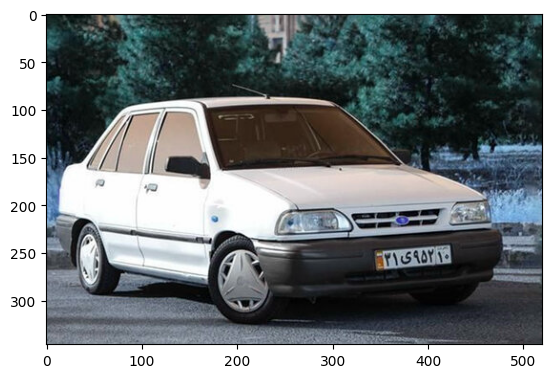

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


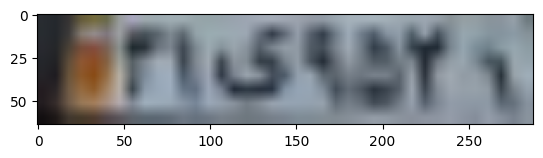

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
49ق24663


In [74]:
pride_img = cv2.imread("pride.png")
visualize(pride_img)
print(read_single(pride_img))